In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objs as go
# import numba
# from numba import jit
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
# %matplotlib qt
# %matplotlib notebook
# import seaborn
from IPython.display import HTML
import plotly.graph_objects as go

In [2]:
plotly.offline.init_notebook_mode()

In [3]:
def derivs_harmonic(state):
    w = 1.0
    result = np.copy(state)
    result[0] = state[0]
    result[1] = state[2]
    result[2] = -w*w*state[1]
    return result

In [4]:
#assumes that the input state has four variables per orbiting object (x,y,vx,vy)
#t is [0], x positions is [1,N], y is [N+1,2N], vx is [2N+1,3N], vy is [3N+1,4N]
BIG_G = 6.67408e-11#6.67408e-11 #(Nm^2)/kg^2
# @jit(nopython=True)
def derivs_2D_gravity(state):    
    N = int((len(state)-1)/4)#number of bodies=(variables-time)/DOF
    derivs = np.copy(state)
    ovx = 2*N
    ovy = 3*N
    force_sum_x = np.zeros(N)
    force_sum_y = np.zeros(N)
    force_sum_x.fill(0.0)
    force_sum_y.fill(0.0)
    for i in range(1,N+1):
        for j in range(i+1,N+1):
            #find distance between objects i and j
            xdist = (state[j]-state[i]) #xj-xi
            ydist = (state[j+N]-state[i+N]) #yj-yi
            dist = np.sqrt(xdist**2+ydist**2)
            
            #force interaction without mass scaling nor G
            f_over_m_x = (xdist/(dist**3))
            f_over_m_y = (ydist/(dist**3))
            
            #add force interaction scaled by mass j to obj i
            force_sum_x[i-1] += masses[j-1]*f_over_m_x
            force_sum_y[i-1] += masses[j-1]*f_over_m_y
            
            #subtract force interaction scaled by mass i to obj j abs
            force_sum_x[j-1] -= masses[i-1]*f_over_m_x
            force_sum_y[j-1] -= masses[i-1]*f_over_m_y
        #fill data gathered for object i
        derivs[i] = state[i+ovx]
        derivs[i+N] = state[i+ovy]
        derivs[i+ovx] = BIG_G*force_sum_x[i-1]
        derivs[i+ovy] = BIG_G*force_sum_y[i-1]
        #clear sum variable for ith object, leave the rest accumulating
        force_sum_x[i-1] = 0.0
        force_sum_y[i-1] = 0.0
    return derivs

In [5]:
#assumes that the input state has 6 variables per orbiting object (x,y,z,vx,vy,vz)
#t is [0], x positions is [1,N], y is [N+1,2N], z is [2N+1,3N],
#vx is [3N+1,4N], vy is [4N+1,5N], vz is [5N+1,6N]
BIG_G = 6.67408e-11 #(Nm^2)/kg^2
def derivs_3D_gravity(state):    
    N = int((len(state)-1)/6)#number of bodies=(variables-time)/DOF
    derivs = np.copy(state)
    oz = 2*N
    ovx = 3*N
    ovy = 4*N
    ovz = 5*N
    force_sum_x = np.zeros(N)
    force_sum_y = np.zeros(N)
    force_sum_z = np.zeros(N)
    force_sum_x.fill(0.0)
    force_sum_y.fill(0.0)
    force_sum_z.fill(0.0)##todo from here down
    for i in range(1,N+1):
        for j in range(i+1,N+1):
            #find distance between objects i and j
            xdist = (state[j]-state[i]) #xj-xi
            ydist = (state[j+N]-state[i+N]) #yj-yi
            zdist = (state[j+oz]-state[i+oz]) #zj-zi
            dist = np.sqrt(xdist**2+ydist**2+zdist**2)
            
            #force interaction without mass scaling nor G
            f_over_m_x = (xdist/(dist**3))
            f_over_m_y = (ydist/(dist**3))
            f_over_m_z = (zdist/(dist**3))
            
            #add force interaction scaled by mass j to obj i
            force_sum_x[i-1] += masses[j-1]*f_over_m_x
            force_sum_y[i-1] += masses[j-1]*f_over_m_y
            force_sum_z[i-1] += masses[j-1]*f_over_m_z
            
            #subtract force interaction scaled by mass i to obj j abs
            force_sum_x[j-1] -= masses[i-1]*f_over_m_x
            force_sum_y[j-1] -= masses[i-1]*f_over_m_y
            force_sum_z[j-1] -= masses[i-1]*f_over_m_z
        #fill data gathered for object i
        derivs[i] = state[i+ovx]
        derivs[i+N] = state[i+ovy]
        derivs[i+oz] = state[i+ovz]
        derivs[i+ovx] = BIG_G*force_sum_x[i-1]
        derivs[i+ovy] = BIG_G*force_sum_y[i-1]
        derivs[i+ovz] = BIG_G*force_sum_z[i-1]
        #clear sum variable for ith object, leave the rest accumulating
        force_sum_x[i-1] = 0.0
        force_sum_y[i-1] = 0.0
        force_sum_z[i-1] = 0.0
    return derivs

In [6]:
#-----------------Dormand-Prince Coefficients--------
dpc=[0,0.0,1.0/5.0,3.0/10.0,4.0/5.0,8.0/9.0,1.0,1.0]
dpb=[0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0];
dpbs=[0,5179.0/57600.0,0.0,7571.0/16695.0,393.0/640.0,-92097.0/339200.0,187.0/2100.0,1.0/40.0];
dpa=[[0,0,0,0,0,0,0],
[0,0,0,0,0,0,0],
[0,1.0/5.0,0,0,0,0,0],
[0,3.0/40.0,9.0/40.0,0,0,0,0],
[0,44.0/45.0,-56.0/15.0,32.0/9.0,0,0,0],
[0,19372.0/6561.0,-25360.0/2187.0,64448.0/6561.0,-212.0/729.0,0,0],
[0,9017.0/3168.0,-355.0/33.0,46732.0/5247.0,49.0/176.0,-5103.0/18656.0,0],
[0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0]]

In [7]:
# @jit(nopython=True)
def rk45_step_try(state, state_derivs, h, deriv_func):
    n = len(state)
    temp_state = np.copy(state)
    new_state = np.copy(state)
    k_all = np.zeros((7,n)) #k storage, 0 index is empty
    k_all[1][:] = h*np.copy(state_derivs) #k_1 is pre-calculated 
    for j in range(2,7): #iterate over k_2 through k_6
        for k in range(1,j): #iterate over existing k values
            #sum k values up to this one
            temp_state[1:] = np.add(temp_state[1:], dpa[j][k]*k_all[k][1:])
        #update temp_state independent variable (temp_state[0])
        temp_state[0] = state[0] + h*dpc[j] 
        #use temp_state to calculate next k values
        k_all[j][:] = h*deriv_func(temp_state)
        #refresh temp_state to hold y_n only again
        temp_state = np.copy(state)    
    #refresh temp state to y_n
    temp_state = np.copy(state)
    temp_state_star = np.copy(state)
    #update time step to a full h step
    temp_state[0] = temp_state[0]+h
    temp_state_star[0] = temp_state_star[0]+h
    #for all elements, add together the b*k's for y_{n+1} and y^*_{n+1}
    for k in range(1,7):
        temp_state[1:] = np.add(temp_state[1:], dpb[k]*k_all[k][1:])
        temp_state_star[1:] = np.add(temp_state_star[1:], dpbs[k]*k_all[k][1:])
    #y_{n+1}* actually gets one more term
    temp_state_star[1:] = np.add(temp_state_star[1:], dpbs[7]*h*(deriv_func(temp_state)[1:]))
    #error calculation
    error = np.copy(state) #same size and shape
    error[0] = 0 #same dependent variable for both
    error[1:] = np.subtract(temp_state[1:],temp_state_star[1:])
    return temp_state, error

In [8]:
#generic rk4 driver for constant step size
#no error checking/input cleaning
#tmin is state_init[0] as the starting independent variable
#returns full data across all variables through tmin
#output[:,0] = t; output[:,1] = x(t); ...
# @jit(nopython=True)
def ghk_rk4(tmax, state_init, h, deriv_func):
    points = int((tmax-state_init[0])/h)
    print("Calculating "+str(points)+" points.")
    derivs_init = deriv_func(state_init)
    state_storage = np.empty((0,len(state_init))) #create 2d array    
    state_storage = np.append(state_storage,[state_init],axis=0) #initial state
    old_state = np.copy(state_init) #used to generate next state
    next_state = np.copy(state_init) #stores new calculated state
    old_derivs = np.copy(derivs_init) #used to generate next state
    for j in range(0,points-1):
        old_state = next_state
        old_derivs = deriv_func(next_state)
        (next_state,error) = rk45_step_try(old_state,old_derivs,h,deriv_func)
#         next_state = rk4_step(old_state,old_derivs,h,deriv_func)
        state_storage = np.append(state_storage,[next_state],axis=0)
        if(j%(int(points*0.1))==0):
            print(str(j)+" points calculated.")
    return state_storage    

In [9]:
#INITIAL_CONDITIONS 2D
radii = [6.96e8, 6.378e6, 3.3934e6, 7.1398e7] #S,E,M,J
masses = [1.9891e30, 5.9742e24, 0.64191e24, 1898.8e24] #S,E,M,J
Sx = 0.0
Ex = 149.598e9
Mx = 228.0e9
Jx = 778.298e9
Sy = 0.0
Ey = 0.0
My = 0.0
Jy = 0.0
Svx = 0.0
Evx = 0.0
Mvx = 0.0
Jvx = 0.0
Svy = -3.0e1
Evy = 2.9786e4
Mvy = 2.4127e4
Jvy = 1.30588e4
init_state = [0.0,Sx,Ex,Mx,Jx,Sy,Ey,My,Jy,Svx,Evx,Mvx,Jvx,Svy,Evy,Mvy,Jvy]

In [10]:
#INITIAL_CONDITIONS 3D
radii_3d = [6.96e8, 6.378e6, 3.3934e6, 7.1398e7] #S,E,M,J
masses_3d = [1.9891e30, 5.9742e24, 0.64191e24, 1898.8e24] #S,E,M,J
Sx = 0.0
Ex = 149.598e9
Mx = 228.0e9
Jx = 778.298e9
Sy = 0.0
Ey = 0.0
My = 0.0
Jy = 0.0
Sz = 0.0
Ez = 0.0
Mz = 0.0
Jz = 0.0
Svx = 0.0
Evx = 0.0
Mvx = 0.0
Jvx = 0.0
Svy = -3.0e1
Evy = 2.9786e4
Mvy = 2.4127e4
Jvy = 1.30588e4
Svz = 0
Evz = 0
Mvz = 0
Jvz = 0
init_state_3d = [0.0,Sx,Ex,Mx,Jx,Sy,Ey,My,Jy,Sz,Ez,Mz,Jz,Svx,Evx,Mvx,Jvx,Svy,Evy,Mvy,Jvy,Svz,Evz,Mvz,Jvz]

In [11]:
#try the harmonic oscillator
# harmonic_data = ghk_rk4(20*np.pi, [0.0,1.0,0.0], .01, derivs_harmonic)

In [12]:
# plt.plot(harmonic_data[:,0],harmonic_data[:,1]);
# plt.plot(harmonic_data[:,0],harmonic_data[:,2]);

In [13]:
# plt.plot(harmonic_data[:,1],harmonic_data[:,2]);
# plt.axis('square');

In [14]:
orbits = ghk_rk4(25e7, init_state, 1e4, derivs_2D_gravity)

Calculating 25000 points.
0 points calculated.
2500 points calculated.
5000 points calculated.
7500 points calculated.
10000 points calculated.
12500 points calculated.
15000 points calculated.
17500 points calculated.
20000 points calculated.
22500 points calculated.


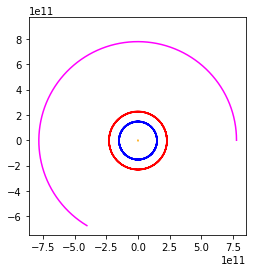

In [15]:
# %matplotlib inline 
plt.plot(orbits[:,1],orbits[:,1+len(masses)],'orange');
plt.plot(orbits[:,2],orbits[:,2+len(masses)],'blue');
plt.plot(orbits[:,3],orbits[:,3+len(masses)],'red');
plt.plot(orbits[:,4],orbits[:,4+len(masses)],'magenta');
plt.axis('square');

In [16]:
orbits = ghk_rk4(10e7, init_state_3d, 1e4, derivs_3D_gravity)

Calculating 10000 points.
0 points calculated.
1000 points calculated.
2000 points calculated.
3000 points calculated.
4000 points calculated.
5000 points calculated.
6000 points calculated.
7000 points calculated.
8000 points calculated.
9000 points calculated.


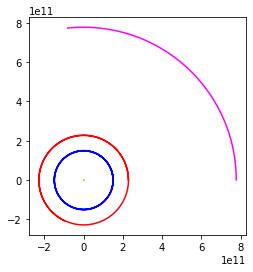

In [17]:
# %matplotlib inline 
plt.plot(orbits[:,1],orbits[:,1+len(masses)],'orange');
plt.plot(orbits[:,2],orbits[:,2+len(masses)],'blue');
plt.plot(orbits[:,3],orbits[:,3+len(masses)],'red');
plt.plot(orbits[:,4],orbits[:,4+len(masses)],'magenta');
plt.axis('square');

In [18]:
#make 3d plot of chaotic system data for rossler and lorenz systems
# copied from https://stackoverflow.com/questions/38364435/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook
# and https://plotly.com/python/3d-line-plots/
def plot_3d_custom(data_3d):
    #configure traces of all objects:
    colors = ['orange','blue','red','magenta']
    bodies = len(masses)
    data = []
    for i in range(0,bodies):
        # Configure the trace.
        trace = go.Scatter3d(
            x=data_3d[:,i+1],  # <-- Put your data instead
            y=data_3d[:,i+1+bodies],  # <-- Put your data instead
            z=data_3d[:,i+1+2*bodies],  # <-- Put your data instead
            mode='lines',
#             marker={
#                 'size': radii_3d[i]/min(radii_3d),
#                 'opacity': 0.8,
#             },
            line=dict(
            color=colors[i],
            width=radii_3d[i]/(2*min(radii_3d))
            )
        )
        data.append(trace)
    
    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )

#     data = [trace_1,trace_2]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)

In [19]:
plot_3d_custom(orbits)

In [20]:

# # # Import pandas library
# # import pandas as pd
 
# # # initialize list of lists
# # data = [['tom', 10], ['nick', 15], ['juli', 14]]
 
# # # Create the pandas DataFrame
# # df = pd.DataFrame(data, columns = ['Name', 'Age'])
 
# # # print dataframe.
# # df

# import pandas as pd
# data = []
# for i in range(0, orbits.shape[0]):
#     chunk = ['sun',orbits[i,0]/10000,orbits[i,1],orbits[i,1+len(masses)]]
#     data.append(chunk)
#     chunk = ['earth',orbits[i,0]/10000,orbits[i,2],orbits[i,2+len(masses)]]
#     data.append(chunk)
#     chunk = ['mars',orbits[i,0]/10000,orbits[i,3],orbits[i,3+len(masses)]]
#     data.append(chunk)
#     chunk = ['jupiter',orbits[i,0]/10000,orbits[i,4],orbits[i,4+len(masses)]]
#     data.append(chunk)
# df = pd.DataFrame(data, columns = ['body', 'body_time', 'body_xpos', 'body_ypos'])
# # df

In [21]:
# fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100
# fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5

In [22]:
# import plotly.express as px

# # df = px.data.gapminder()

# # fig = px.bar(df, x="continent", y="pop", color="continent",
# #   animation_frame="year", animation_group="country", range_y=[0,4000000000])
# # fig.show()

# fig = px.scatter(df, x="body_xpos", y="body_ypos", color='body',
#   animation_frame="body_time", animation_group="body", range_y=[-8e11,8e11], range_x=[-8e11,8e11])
# fig.update_yaxes(
#     scaleanchor = "x",
#     scaleratio = 1,
#   )
# fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100
# fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
# fig.show()